In [4]:
#Connecting Drive to access Kaggle json file to download Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Copy contenets from drive and set path
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle_json/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Checking contents in file
!ls ~/.kaggle/

kaggle.json


In [7]:
# Download the breast ultrasound images dataset from Kaggle
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 99% 193M/195M [00:10<00:00, 23.2MB/s]
100% 195M/195M [00:10<00:00, 19.9MB/s]


In [8]:
# Unzip the dataset
!unzip breast-ultrasound-images-dataset.zip -d /content/dataset

Archive:  breast-ultrasound-images-dataset.zip
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: /content/dataset/Dataset_BUSI_with_GT/benign/benign (103).png  
  i

In [9]:
# List the contents of the dataset
!ls /content/dataset

Dataset_BUSI_with_GT


In [10]:
!ls /content/dataset/Dataset_BUSI_with_GT

benign	malignant  normal


In [11]:
#Import required libraries
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from imgaug import augmenters as iaa
from tqdm import tqdm
from skimage import restoration
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchvision.models import GoogLeNet_Weights, AlexNet_Weights

In [12]:
# Splitting datasets in 6:2:2 ratio

# Define paths
base_dir = '/content/dataset/Dataset_BUSI_with_GT'
output_dir = '/content/dataset_split'

# Make directories for train, validation, and test sets
for subset in ['train', 'val', 'test']:
    for category in ['malignant', 'benign', 'normal']:
        os.makedirs(os.path.join(output_dir, subset, category), exist_ok=True)

# Function to split and copy files
def split_and_copy_files(category):
    category_path = os.path.join(base_dir, category)
    images = [f for f in os.listdir(category_path) if f.endswith('.png') or f.endswith('.jpg')]  # adjust based on your file type

    # Split into train, val, and test sets
    train, temp = train_test_split(images, test_size=0.4, random_state=42)  # 60% train
    val, test = train_test_split(temp, test_size=0.5, random_state=42)      # 20% val, 20% test

    # Copy files
    for dataset, subset in zip([train, val, test], ['train', 'val', 'test']):
        for filename in dataset:
            src = os.path.join(category_path, filename)
            dst = os.path.join(output_dir, subset, category, filename)
            shutil.copy(src, dst)

# Apply the function to each category
for category in ['malignant', 'benign', 'normal']:
    split_and_copy_files(category)

print("Dataset split into train, val, and test sets successfully.")


Dataset split into train, val, and test sets successfully.


In [13]:
!ls /content/dataset_split

test  train  val


In [14]:
!ls /content/dataset_split/train
!ls /content/dataset_split/val
!ls /content/dataset_split/test

benign	malignant  normal
benign	malignant  normal
benign	malignant  normal


In [15]:
# Count number of images in each split

# Define the path to the split dataset
output_dir = '/content/dataset_split'

# Function to count images in each split and category
def count_images():
    counts = {}
    for subset in ['train', 'val', 'test']:
        counts[subset] = {}
        for category in ['malignant', 'benign', 'normal']:
            category_path = os.path.join(output_dir, subset, category)
            counts[subset][category] = len([f for f in os.listdir(category_path) if f.endswith('.png') or f.endswith('.jpg')])

    # Display counts
    for subset, categories in counts.items():
        print(f"\n{subset.capitalize()} split:")
        for category, count in categories.items():
            print(f"  {category.capitalize()}: {count} images")

# Run the function to count images
count_images()



Train split:
  Malignant: 252 images
  Benign: 534 images
  Normal: 159 images

Val split:
  Malignant: 84 images
  Benign: 178 images
  Normal: 53 images

Test split:
  Malignant: 85 images
  Benign: 179 images
  Normal: 54 images


In [16]:
# Apply augumentations like Rotations and Translations

# Define paths
input_dir = '/content/dataset_split'
output_dir = '/content/dataset_augmented'

# Create output directories for augmented data
for subset in ['train', 'val', 'test']:
    for category in ['malignant', 'benign', 'normal']:
        os.makedirs(os.path.join(output_dir, subset, category), exist_ok=True)

# Define augmentation sequence with rotation and translation
augmentation_seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

# Function to apply augmentation and save images
def augment_and_save_images():
    for subset in ['train', 'val', 'test']:
        for category in ['malignant', 'benign', 'normal']:
            input_category_path = os.path.join(input_dir, subset, category)
            output_category_path = os.path.join(output_dir, subset, category)

            # Loop over each image in the category directory
            for filename in tqdm(os.listdir(input_category_path), desc=f"Processing {subset}/{category}"):
                if filename.endswith('.png') or filename.endswith('.jpg'):

                    img_path = os.path.join(input_category_path, filename)
                    image = cv2.imread(img_path)

                    cv2.imwrite(os.path.join(output_category_path, filename), image)

                    for i in range(5):
                        augmented_image = augmentation_seq(image=image)
                        aug_img_path = os.path.join(output_category_path, f"aug_{i}_{filename}")
                        cv2.imwrite(aug_img_path, augmented_image)

# Run the augmentation function
augment_and_save_images()


Processing test/normal: 100%|██████████| 54/54 [00:04<00:00, 11.56it/s]


In [17]:
# Count number of images in each split after Augumentation

# Define the path to the split dataset
output_dir = '/content/dataset_augmented'

def count_images():
    counts = {}
    for subset in ['train', 'val', 'test']:
        counts[subset] = {}
        for category in ['malignant', 'benign', 'normal']:
            category_path = os.path.join(output_dir, subset, category)
            counts[subset][category] = len([f for f in os.listdir(category_path) if f.endswith('.png') or f.endswith('.jpg')])

    for subset, categories in counts.items():
        print(f"\n{subset.capitalize()} split:")
        for category, count in categories.items():
            print(f"  {category.capitalize()}: {count} images")

count_images()



Train split:
  Malignant: 1512 images
  Benign: 3204 images
  Normal: 954 images

Val split:
  Malignant: 504 images
  Benign: 1068 images
  Normal: 318 images

Test split:
  Malignant: 510 images
  Benign: 1074 images
  Normal: 324 images


In [18]:
# Add the images into lists for further use

# Path to the image folder (adjust to your folder structure)
image_folder = '/content/dataset_augmented/train/'

X_train = []
y_train = []

categories = ['malignant', 'benign', 'normal']

for label, category in enumerate(categories):
    category_path = os.path.join(image_folder, category)
    for filename in os.listdir(category_path):
        img_path = os.path.join(category_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        X_train.append(img)
        y_train.append(label)

# Convert X_train and y_train to numpy arrays for further processing
X_train = np.array(X_train)
y_train = np.array(y_train)


In [19]:
# Apply median filtering for noise reduction

kernel_size = 5

X_train_filtered = []

for img in X_train:
    img_filtered = cv2.medianBlur(img, kernel_size)

    X_train_filtered.append(img_filtered)

X_train_filtered = np.array(X_train_filtered)

print(f"Filtered dataset shape: {X_train_filtered.shape}")


Filtered dataset shape: (5670, 224, 224)


In [20]:
# Apply TV(Total Variation) denoising for edge preservation and image restoration

X_train_filtered = X_train_filtered.astype(np.float32)

weight = 0.1

X_train_denoised = []

for img in X_train_filtered:
    img_denoised = restoration.denoise_tv_chambolle(img, weight=weight)

    X_train_denoised.append(img_denoised)

X_train_denoised = np.array(X_train_denoised)

print(f"Denoised dataset shape: {X_train_denoised.shape}")


Denoised dataset shape: (5670, 224, 224)


In [21]:
# Apply Random Upsampling to balance the dataset to avoid inducing any Bias

class_0 = np.where(y_train == 0)  # 'malignant'
class_1 = np.where(y_train == 1)  # 'benign'
class_2 = np.where(y_train == 2)  # 'normal'

X_class_0 = X_train_denoised[class_0]
y_class_0 = y_train[class_0]
X_class_1 = X_train_denoised[class_1]
y_class_1 = y_train[class_1]
X_class_2 = X_train_denoised[class_2]
y_class_2 = y_train[class_2]

X_class_0_upsampled, y_class_0_upsampled = resample(X_class_0, y_class_0, n_samples=len(X_class_1), random_state=42)

X_train_balanced = np.concatenate([X_class_0_upsampled, X_class_1, X_class_2])
y_train_balanced = np.concatenate([y_class_0_upsampled, y_class_1, y_class_2])

print(f"Balanced dataset shape: {X_train_balanced.shape}")


Balanced dataset shape: (7362, 224, 224)


In [22]:
# Set up device and parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001


googlenet = models.googlenet(weights=None, num_classes=3).to(device)
alexnet = models.alexnet(weights=None, num_classes=3).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [23]:
# Data transformations and loading
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='/content/dataset_augmented/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_augmented/val', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [24]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):  # Use main output only
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):  # Use main output only
                    outputs = outputs[0]
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}, "
              f"Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}")

    return train_loss, val_loss, train_acc, val_acc


In [25]:
googlenet_optimizer = optim.Adam(googlenet.parameters(), lr=learning_rate)
alexnet_optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [26]:
print("Training GoogLeNet...")
googlenet_train_loss, googlenet_val_loss, googlenet_train_acc, googlenet_val_acc = \
    train_and_evaluate(googlenet, googlenet_optimizer, criterion, train_loader, val_loader, num_epochs)

print("Training AlexNet...")
alexnet_train_loss, alexnet_val_loss, alexnet_train_acc, alexnet_val_acc = \
    train_and_evaluate(alexnet, alexnet_optimizer, criterion, train_loader, val_loader, num_epochs)


Training GoogLeNet...
Epoch 1/10, Train Loss: 0.7017511224813675, Val Loss: 1.8156955406069755, Train Acc: 69.1358024691358, Val Acc: 54.232804232804234
Epoch 2/10, Train Loss: 0.6245336959536156, Val Loss: 0.7060362686713536, Train Acc: 72.45149911816578, Val Acc: 64.39153439153439
Epoch 3/10, Train Loss: 0.5769212225849709, Val Loss: 0.6388747309645016, Train Acc: 74.09171075837743, Val Acc: 69.8941798941799
Epoch 4/10, Train Loss: 0.5366476353969467, Val Loss: 0.5181020863354207, Train Acc: 75.82010582010582, Val Acc: 75.18518518518519
Epoch 5/10, Train Loss: 0.5067432069041756, Val Loss: 0.7260633416473865, Train Acc: 77.74250440917108, Val Acc: 68.78306878306879
Epoch 6/10, Train Loss: 0.450333041840055, Val Loss: 0.5170838631689548, Train Acc: 81.16402116402116, Val Acc: 75.76719576719577
Epoch 7/10, Train Loss: 0.41628995763786725, Val Loss: 0.4006472667058309, Train Acc: 82.82186948853615, Val Acc: 83.91534391534391
Epoch 8/10, Train Loss: 0.38279886221450365, Val Loss: 0.38321

In [27]:

# Calculate the final results for GoogLeNet
final_googlenet_train_loss = sum(googlenet_train_loss) / len(googlenet_train_loss)
final_googlenet_val_loss = sum(googlenet_val_loss) / len(googlenet_val_loss)
final_googlenet_train_acc = sum(googlenet_train_acc) / len(googlenet_train_acc)
final_googlenet_val_acc = sum(googlenet_val_acc) / len(googlenet_val_acc)

# Print final GoogLeNet results
print(f"Final GoogLeNet Training Loss: {final_googlenet_train_loss:.4f}")
print(f"Final GoogLeNet Validation Loss: {final_googlenet_val_loss:.4f}")
print(f"Final GoogLeNet Training Accuracy: {final_googlenet_train_acc:.2f}%")
print(f"Final GoogLeNet Validation Accuracy: {final_googlenet_val_acc:.2f}%")

# Calculate the final results for AlexNet
final_alexnet_train_loss = sum(alexnet_train_loss) / len(alexnet_train_loss)
final_alexnet_val_loss = sum(alexnet_val_loss) / len(alexnet_val_loss)
final_alexnet_train_acc = sum(alexnet_train_acc) / len(alexnet_train_acc)
final_alexnet_val_acc = sum(alexnet_val_acc) / len(alexnet_val_acc)

# Print final AlexNet results
print(f"Final AlexNet Training Loss: {final_alexnet_train_loss:.4f}")
print(f"Final AlexNet Validation Loss: {final_alexnet_val_loss:.4f}")
print(f"Final AlexNet Training Accuracy: {final_alexnet_train_acc:.2f}%")
print(f"Final AlexNet Validation Accuracy: {final_alexnet_val_acc:.2f}%")


Final GoogLeNet Training Loss: 0.4918
Final GoogLeNet Validation Loss: 0.6468
Final GoogLeNet Training Accuracy: 78.72%
Final GoogLeNet Validation Accuracy: 74.34%
Final AlexNet Training Loss: 0.6811
Final AlexNet Validation Loss: 0.7116
Final AlexNet Training Accuracy: 68.79%
Final AlexNet Validation Accuracy: 67.32%


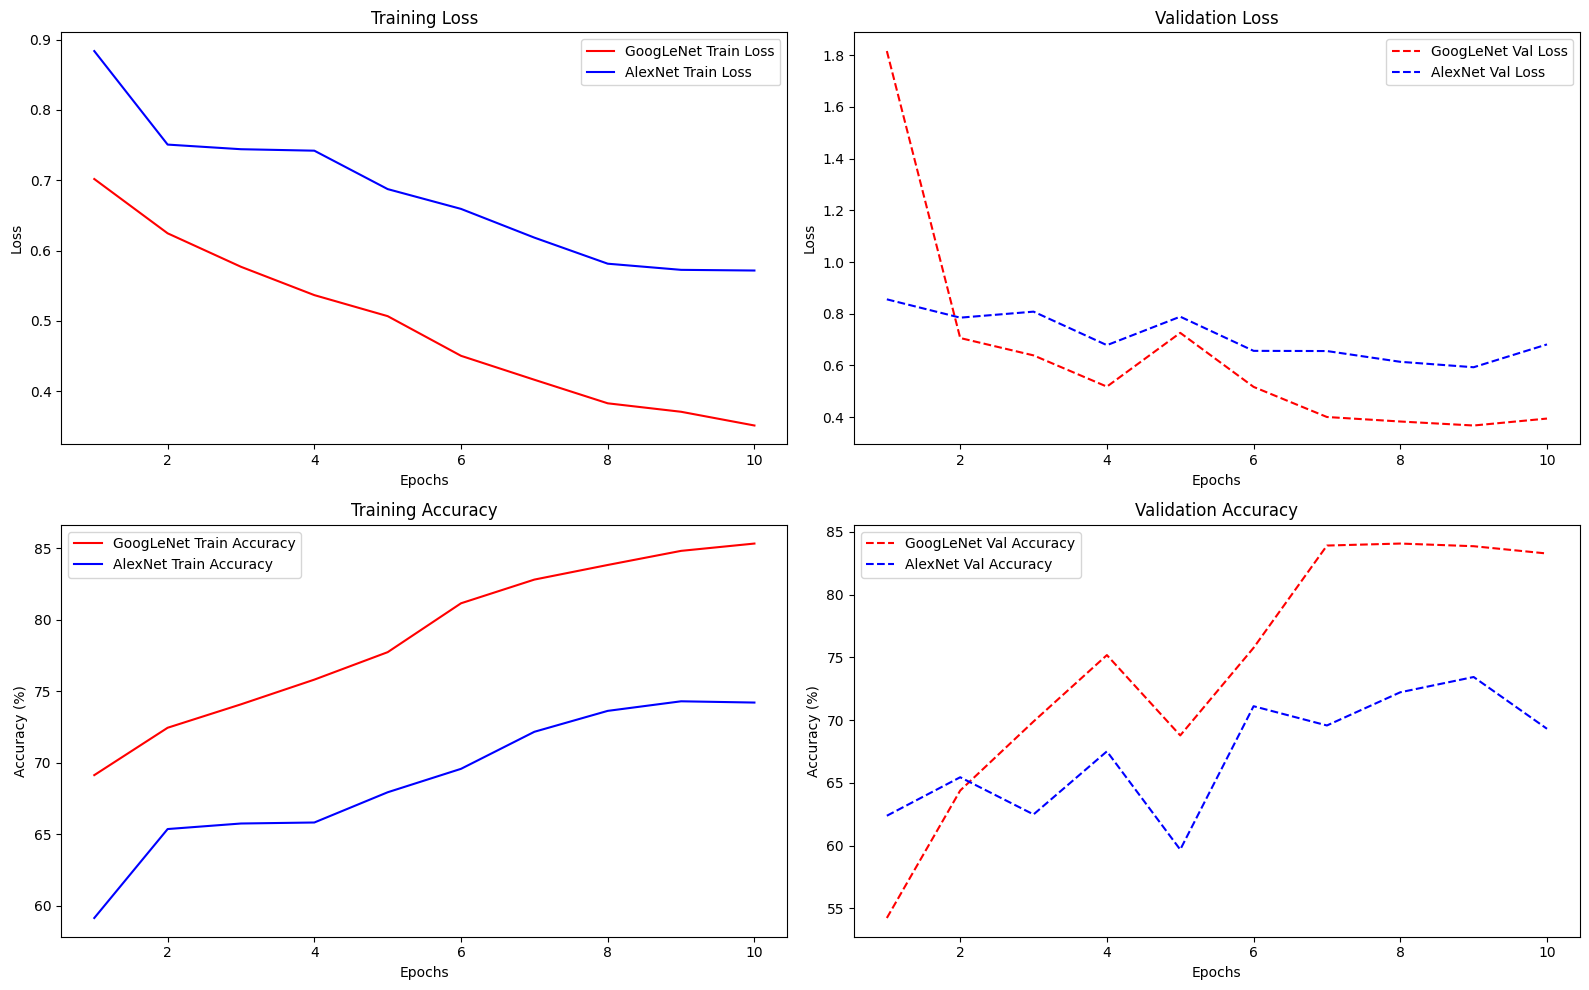

In [28]:
# Plot results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, googlenet_train_loss, 'r-', label='GoogLeNet Train Loss')
plt.plot(epochs, alexnet_train_loss, 'b-', label='AlexNet Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, googlenet_val_loss, 'r--', label='GoogLeNet Val Loss')
plt.plot(epochs, alexnet_val_loss, 'b--', label='AlexNet Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, googlenet_train_acc, 'r-', label='GoogLeNet Train Accuracy')
plt.plot(epochs, alexnet_train_acc, 'b-', label='AlexNet Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy')

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, googlenet_val_acc, 'r--', label='GoogLeNet Val Accuracy')
plt.plot(epochs, alexnet_val_acc, 'b--', label='AlexNet Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [29]:
# Test Dataset
test_dataset = datasets.ImageFolder(root='/content/dataset_augmented/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [30]:
def evaluate_on_test(model, test_loader, criterion, epoch=None):
    model.eval()
    correct, total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):  # For GoogLeNet
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    # Print test loss and accuracy for the current epoch
    if epoch is not None:
        print(f"Epoch [{epoch+1}] - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    else:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy


In [31]:
print("GoogleNet:")
googlenet_test_loss, googlenet_test_acc = evaluate_on_test(googlenet, test_loader, criterion)
print("AlexNet:")
alexnet_test_loss, alexnet_test_acc = evaluate_on_test(alexnet, test_loader, criterion)


GoogleNet:
Test Loss: 0.4212, Test Accuracy: 84.49%
AlexNet:
Test Loss: 0.6506, Test Accuracy: 70.02%
